In [1]:
import sys
sys.path.append("/home/oliver/doc-forest_clis_ba_ws21/nice")

import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
from tqdm import tqdm

import scienceplots
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use(['science','ieee'])
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

import seaborn as sns
sns.set_color_codes()

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, LeavePGroupsOut, LeaveOneGroupOut
from sklearn.metrics import auc, RocCurveDisplay, accuracy_score, roc_curve

In [2]:
in_path = "../../data/processed/seeg_features_epochs_15min.csv"
df_features = pd.read_csv(in_path, index_col=[0, 1, 2], header=[0, 1, 2]).dropna()
df_features.index = df_features.index.set_levels(pd.to_timedelta(df_features.index.levels[2]), level=2)
df_features.columns.names = list(map(lambda x: x.replace("fun", "function"), df_features.columns.names))

psd_columns = ["nice/marker/PowerSpectralDensity/alpha",
               "nice/marker/PowerSpectralDensity/beta",
               "nice/marker/PowerSpectralDensity/delta",
               "nice/marker/PowerSpectralDensity/gamma",
               "nice/marker/PowerSpectralDensity/theta"]
drop_psd = True
if drop_psd:
    df_features = df_features.drop(columns=psd_columns)

<ipython-input-2-90a82147ab46>:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_features = df_features.drop(columns=psd_columns)


In [3]:
clf = ExtraTreesClassifier(n_estimators=2000, max_features=1, max_depth=4, criterion="entropy", n_jobs=-1)

0.31184685605286466


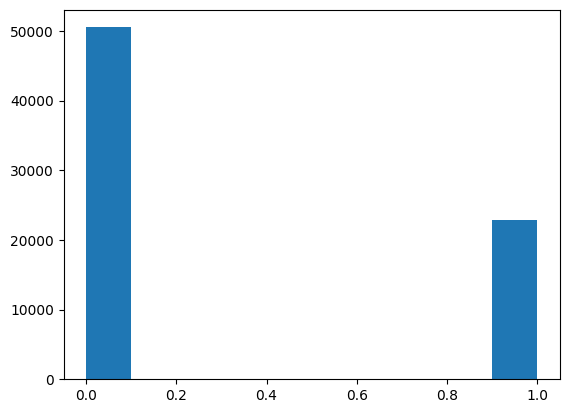

In [4]:
X = df_features.values
# group cv by patients
groups = df_features.index.get_level_values(0).values
y = pd.Series(df_features.index.get_level_values(1)).replace({"conscious": 1, "unconscious": 0}).values
print(y.mean())
plt.hist(y);

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


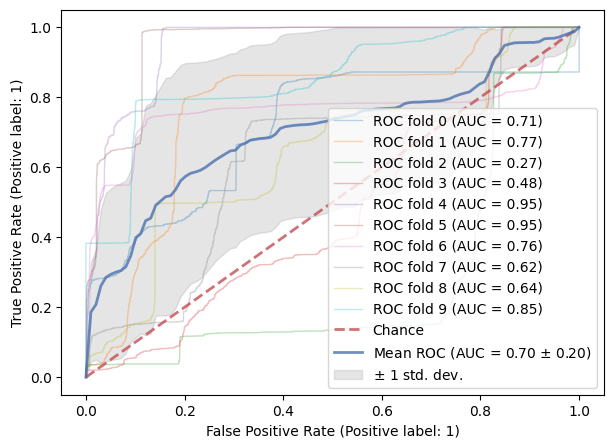

In [5]:
# plot roc curves, get feature importances
cv = GroupShuffleSplit(n_splits=10, test_size=0.15)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
cv_variable_importances = pd.DataFrame(index=df_features.columns)

fig, ax = plt.subplots(figsize=(7, 5))
for i, (train, test) in tqdm(list(enumerate(cv.split(X, y, groups)))):
    clf.fit(X[train], y[train])
    # capture MDI
    vi = pd.Series(clf.feature_importances_, index=df_features.columns, name=i)
    cv_variable_importances = cv_variable_importances.join(vi)
    
    # diplay curve
    viz = RocCurveDisplay.from_estimator(
        clf,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)    

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")
plt.show()

cv_variable_importances.index = [("/".join(a.split("/")[-2:]), b, c) for a, b, c in cv_variable_importances.index]

<Figure size 640x480 with 0 Axes>

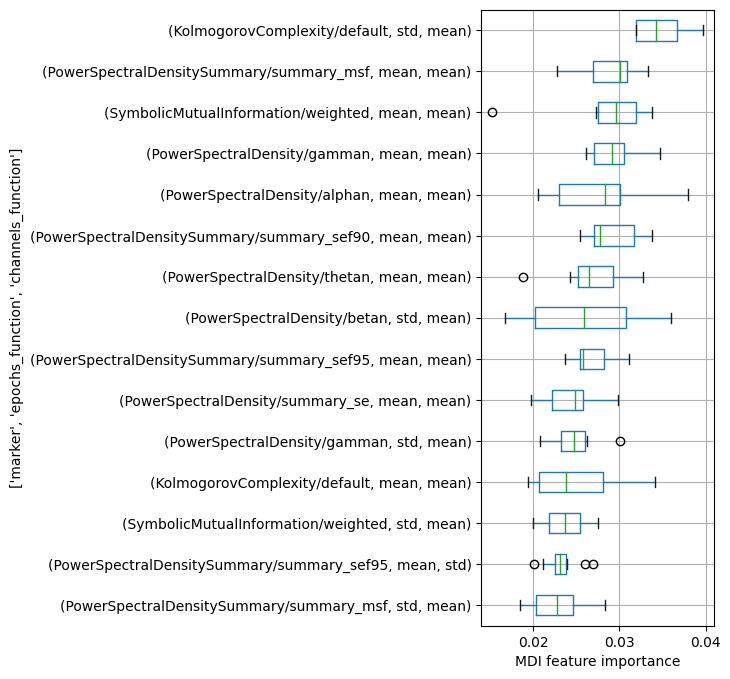

In [6]:
top_n = 15

plt.clf()
fig, ax = plt.subplots(figsize=(3, 8))

df_mdi_plot = cv_variable_importances.iloc[np.argsort(cv_variable_importances.median(axis=1)).values].tail(top_n).T
#df_mdi_plot.columns = [(x.replace("/", "/\n"), y, z) for x, y, z in df_mdi_plot.columns]
ax = df_mdi_plot.boxplot(vert=False)
ax.set_xlabel("MDI feature importance")
ax.set_ylabel(df_features.columns.names)
#ax.set_title("ExtraTrees Feature Importances (MDI)\n for CV train sets")
fig = ax.get_figure()
plt.show()